#### here we try to generate all the plots from the stat files

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from astropy import units as u
from astropy.coordinates import SkyCoord

from matplotlib import pyplot as plt

#### Precision and Recall histograms considering enough statistics

We just consider the computation of precision and recall when the number of tp > 100. This allow us to systematically produce stable results

In [2]:
#construction of precision and recall curves checking that the
#statistics is enough to get reliable values

def flux_metrics_stable(bins, hist_tp_flux_1, hist_fp_flux_1, hist_fn_flux_1, threshold):

    hist_precision_flux_1 = []
    hist_recall_flux_1 = []
    hist_precision_times_recall_1 = []
    
    bins_flux = []
    
    tp_st = 0
    fp_st = 0
    fn_st = 0
    
    last_con = 0
    bins_con = 0
    
    for con in range(len(hist_tp_flux_1)):

        tp_st = tp_st + hist_tp_flux_1[con]
        fp_st = fp_st + hist_fp_flux_1[con]
        fn_st = fn_st + hist_fn_flux_1[con]
        
        #we require enough statistics to compute precision and recall
        #and then we restart
        #if (tp_st >= threshold or fp_st > threshold or fn_st > threshold):
        if (tp_st >= threshold):
            
            precision = 0
            recall = 0
            
            if ((tp_st + fp_st) > 0):
                precision = tp_st/(tp_st + fp_st)
            
            if ((tp_st + fn_st) > 0):
                recall = tp_st/(tp_st + fn_st)
                
            #print(bins[con], tp_st, fp_st, fn_st, precision, recall)    
                
            bins_flux.append(bins[con])
                    
            hist_precision_flux_1.append(precision)
            hist_recall_flux_1.append(recall)
        
            hist_precision_times_recall_1.append(precision*recall)
            
            tp_st = 0
            fp_st = 0
            fn_st = 0
            
            last_con = con
            
    #the last bin is filled at the end of the process
    #if (tp_st >= threshold or fp_st > threshold or fn_st > threshold):
    if (tp_st >= threshold):
        precision = 0
        recall = 0
            
        if ((tp_st + fp_st) > 0):
            precision = tp_st/(tp_st + fp_st)
            
        if ((tp_st + fn_st) > 0):
            recall = tp_st/(tp_st + fn_st)
                
        bins_flux.append(bins[last_con + 1])
                    
        hist_precision_flux_1.append(precision)
        hist_recall_flux_1.append(recall)
        
        hist_precision_times_recall_1.append(precision*recall)
            
        tp_st = 0
        fp_st = 0
        fn_st = 0
        
    return bins_flux, hist_precision_flux_1, hist_recall_flux_1, hist_precision_times_recall_1

In [3]:
def plot_metrics_flux_F1000_latabove(path_to_stat_1, legend_loc, lat_th, stat_th, vthreshold):
    
    ###########################################################################################
    #Read files
    ##########################################################################################
       
    stat_data_1  = pd.read_csv(f"{path_to_stat_1}")
           
    ############################################################################################    
        
    condition_tp_1 = ((stat_data_1["stat_code"] == 0) & (abs(stat_data_1["test_lat"]) > lat_th))
    condition_fp_1 = ((stat_data_1["stat_code"] == 1) & (abs(stat_data_1["test_lat"]) > lat_th))
    condition_fn_1 = ((stat_data_1["stat_code"] == 2) & (abs(stat_data_1["test_lat"]) > lat_th))
    
    ############################################################################################
    
    stat_data_tp_flux_1 = np.array(stat_data_1.loc[condition_tp_1, "test_flux_1000"])
    stat_data_fp_flux_1 = np.array(stat_data_1.loc[condition_fp_1, "test_flux_1000"])
    stat_data_fn_flux_1 = np.array(stat_data_1.loc[condition_fn_1, "test_flux_1000"])
    
    #############################################################################################
    
    stat_data_tp_flux_1 = np.abs(stat_data_tp_flux_1)
    stat_data_fp_flux_1 = np.abs(stat_data_fp_flux_1)
    stat_data_fn_flux_1 = np.abs(stat_data_fn_flux_1)
    
    #############################################################################################
    
    bins=np.logspace(np.log10(1e-12),np.log10(1e-7), 20)
    
    hist_tp_flux_1, _ = np.histogram(stat_data_tp_flux_1, bins=bins)
    hist_fp_flux_1, _ = np.histogram(stat_data_fp_flux_1, bins=bins)
    hist_fn_flux_1, _ = np.histogram(stat_data_fn_flux_1, bins=bins)
    
    #histograms with stable metrics results
    
    #print("F0_B4, precision, recall")
    bins_flux_1, hist_precision_flux_1, hist_recall_flux_1, hist_precision_times_recall_1 = flux_metrics_stable(bins, hist_tp_flux_1, hist_fp_flux_1, hist_fn_flux_1, stat_th)
    
    ##########################################################################################
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_precision_flux_1, color="red")
    ax.plot(bins_flux_1, hist_precision_flux_1, '-o', label=f"UNEK-F0-B1", color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| > {lat_th}°", fontsize=14)
    
    plt.show() 
    ####################################################################################3
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_recall_flux_1, color="red")
    ax.plot(bins_flux_1, hist_recall_flux_1, '-o', label=f"UNEK-F0-B1", color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   
    
    #Purity times Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_precision_times_recall_1, color="red")
    ax.plot(bins_flux_1, hist_precision_times_recall_1, '-o', label=f"UNEK-F0-B1", color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity x Completness", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[2], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   


    return 0

def plot_metrics_flux_F1000_latbelow(path_to_stat_1, legend_loc, lat_th, stat_th, vthreshold):
    
    ########################################
    
    stat_data_1  = pd.read_csv(f"{path_to_stat_1}")
    
    ########################################
    
    condition_tp_1 = ((stat_data_1["stat_code"] == 0) & (abs(stat_data_1["test_lat"]) < lat_th))
    condition_fp_1 = ((stat_data_1["stat_code"] == 1) & (abs(stat_data_1["test_lat"]) < lat_th))
    condition_fn_1 = ((stat_data_1["stat_code"] == 2) & (abs(stat_data_1["test_lat"]) < lat_th))
    
    ########################################
    
    stat_data_tp_flux_1 = np.array(stat_data_1.loc[condition_tp_1, "test_flux_1000"])
    stat_data_fp_flux_1 = np.array(stat_data_1.loc[condition_fp_1, "test_flux_1000"])
    stat_data_fn_flux_1 = np.array(stat_data_1.loc[condition_fn_1, "test_flux_1000"])
    
    ###########################################################
    
    stat_data_tp_flux_1 = np.abs(stat_data_tp_flux_1)
    stat_data_fp_flux_1 = np.abs(stat_data_fp_flux_1)
    stat_data_fn_flux_1 = np.abs(stat_data_fn_flux_1)
    
    ###########################################################
    
    bins=np.logspace(np.log10(1e-12),np.log10(1e-7), 20)
      
    hist_tp_flux_1, _ = np.histogram(stat_data_tp_flux_1, bins=bins)
    hist_fp_flux_1, _ = np.histogram(stat_data_fp_flux_1, bins=bins)
    hist_fn_flux_1, _ = np.histogram(stat_data_fn_flux_1, bins=bins)
    
    #####################################################################
    
    #histograms with stable metrics results
    bins_flux_1, hist_precision_flux_1, hist_recall_flux_1, hist_precision_times_recall_1 = flux_metrics_stable(bins, hist_tp_flux_1, hist_fp_flux_1, hist_fn_flux_1, stat_th) 

    #################################################################
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_precision_flux_1, color="red")
    ax.plot(bins_flux_1, hist_precision_flux_1, '-o', label=f"UNEK-F0-B1", color="red") 
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| < {lat_th}°", fontsize=14)
    plt.show() 
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_recall_flux_1, color="red")
    ax.plot(bins_flux_1, hist_recall_flux_1, '-o', label=f"UNEK-F0-B1", color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| < {lat_th}°", fontsize=14)
    plt.show()   
    
    #Purity times Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_precision_times_recall_1, color="red")
    ax.plot(bins_flux_1, hist_precision_times_recall_1, '-o', label=f"UNEK-F0-B1", color="red")
      
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity x Completness", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[2], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| < {lat_th}°", fontsize=14)
    plt.show()   

    return 0

### SNR plots

In [4]:
def stable_metrics_snr(bins, hist_tp, hist_fp, hist_fn, threshold):

    hist_precision = []
    hist_recall = []
    hist_precision_times_recall = []
    
    bins_snr = []
    
    tp_st = 0
    fp_st = 0
    fn_st = 0
    
    last_con = 0
    bins_con = 0
    
    for con in range(len(hist_tp)):

        tp_st = tp_st + hist_tp[con]
        fp_st = fp_st + hist_fp[con]
        fn_st = fn_st + hist_fn[con]
        
        #we require enough statistics to compute precision and recall
        #and then we restart
        #if (tp_st >= threshold or fp_st > threshold or fn_st > threshold):
        if (tp_st >= threshold):
            
            precision = 0
            recall = 0
            
            if ((tp_st + fp_st) > 0):
                precision = tp_st/(tp_st + fp_st)
            
            if ((tp_st + fn_st) > 0):
                recall = tp_st/(tp_st + fn_st)
                #print(bins[con], tp_st, fn_st)
                
            bins_snr.append(bins[con])
                    
            hist_precision.append(precision)
            hist_recall.append(recall)
        
            hist_precision_times_recall.append(precision*recall)
            
            tp_st = 0
            fp_st = 0
            fn_st = 0
            
            last_con = con
            
    #the last bin is filled at the end of the process
    #if (tp_st >= threshold or fp_st > threshold or fn_st > threshold):
    if (tp_st >= threshold):
        precision = 0
        recall = 0
            
        if ((tp_st + fp_st) > 0):
            precision = tp_st/(tp_st + fp_st)
            
        if ((tp_st + fn_st) > 0):
            recall = tp_st/(tp_st + fn_st)
                
        bins_snr.append(bins[last_con + 1])
                    
        hist_precision.append(precision)
        hist_recall.append(recall)
        
        hist_precision_times_recall.append(precision*recall)
            
        tp_st = 0
        fp_st = 0
        fn_st = 0
        
    ###############################################################
    
    return bins_snr, hist_precision, hist_recall, hist_precision_times_recall

In [5]:
def plot_metrics_snr_all(path_to_stat_1, legend_loc, stat_th, vthreshold):
    
    ##############################################################################
    #UNEK stat data
    ##############################################################################
    
    stat_data_1  = pd.read_csv(f"{path_to_stat_1}")
        
    condition_tp = ((stat_data_1["stat_code"] == 0))
    condition_fp = ((stat_data_1["stat_code"] == 1))
    condition_fn = ((stat_data_1["stat_code"] == 2))
    
    stat_data_tp = np.array(stat_data_1.loc[condition_tp, "snr_center_pred"])
    stat_data_fp = np.array(stat_data_1.loc[condition_fp, "snr_center_pred"])
    stat_data_fn = np.array(stat_data_1.loc[condition_fn, "snr_center_pred"])
    
    stat_data_tp = np.abs(stat_data_tp)
    stat_data_fp = np.abs(stat_data_fp)
    stat_data_fn = np.abs(stat_data_fn)
    
    ############################################################################
    bins = np.logspace(np.log10(1e-2),np.log10(100), 20)
    ############################################################################
          
    ############################################################################
    #UNEK histograms
    ############################################################################
        
    hist_tp, _ = np.histogram(stat_data_tp, bins=bins)
    hist_fp, _ = np.histogram(stat_data_fp, bins=bins)
    hist_fn, _ = np.histogram(stat_data_fn, bins=bins)
    
    #histograms with stable metrics results
    bins_snr, hist_precision, hist_recall, hist_precision_times_recall = stable_metrics_snr(bins, hist_tp, hist_fp, hist_fn, stat_th) 

    ###########################################################################
    #Plots
    ###########################################################################
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    #unek
    ax.scatter(bins_snr, hist_precision, color="red")
    ax.plot(bins_snr, hist_precision, '-o', label=f"UNEK-F0-B1", color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(3e-1, 70)
    ax.set_xticks([1, 10, 70])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"SNR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    #ax.text(0.2, 0.6, f"|b| > {lat_th}°", fontsize=14)
    plt.show() 
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    #unek
    ax.scatter(bins_snr, hist_recall, color="red")
    ax.plot(bins_snr, hist_recall, '-o', label=f"UNEK-F0-B1", color="red")

    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    #ax.set_xlim(1e-2, 10)
    #ax.set_xticks([1e-2, 1e-1, 1, 10])
    ax.set_xlim(3e-1,70)
    ax.set_xticks([1, 10, 70])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"SNR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    #ax.text(0.2, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   
    
    #Purity times Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_snr, hist_precision_times_recall, color="red")
    ax.plot(bins_snr, hist_precision_times_recall, '-o', label=f"UNEK-F0-B1", color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    #ax.set_xlim(1e-2, 10)
    #ax.set_xticks([1e-2, 1e-1, 1, 10])
    ax.set_xlim(3e-1, 70)
    ax.set_xticks([1, 10, 70])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity x Completness", fontsize=14)
    ax.set_xlabel(r"SNR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[2], lw=0.8)
    #ax.text(0.2, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   


    return 0

In [27]:
def plot_metrics_sbr_all(path_to_stat_1, legend_loc, stat_th, vthreshold):
    
    ##############################################################################
    #UNEK stat data
    #############################################################################
    
    stat_data_1  = pd.read_csv(f"{path_to_stat_1}")
        
    condition_tp = ((stat_data_1["stat_code"] == 0))
    condition_fp = ((stat_data_1["stat_code"] == 1))
    condition_fn = ((stat_data_1["stat_code"] == 2))
    
    stat_data_tp = np.array(stat_data_1.loc[condition_tp, "sbr_center_pred"])
    stat_data_fp = np.array(stat_data_1.loc[condition_fp, "sbr_center_pred"])
    stat_data_fn = np.array(stat_data_1.loc[condition_fn, "sbr_center_pred"])
    
    stat_data_tp = np.abs(stat_data_tp)
    stat_data_fp = np.abs(stat_data_fp)
    stat_data_fn = np.abs(stat_data_fn)
     
    ############################################################################
    bins = np.logspace(np.log10(1e-2),np.log10(100), 20)
    ############################################################################
          
    ############################################################################
    #UNEK histograms
    ############################################################################
        
    hist_tp, _ = np.histogram(stat_data_tp, bins=bins)
    hist_fp, _ = np.histogram(stat_data_fp, bins=bins)
    hist_fn, _ = np.histogram(stat_data_fn, bins=bins)
    
    #histograms with stable metrics results
    bins_snr, hist_precision, hist_recall, hist_precision_times_recall = stable_metrics_snr(bins, hist_tp, hist_fp, hist_fn, stat_th) 

    ###########################################################################
    #Plots
    ###########################################################################
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    #unek
    ax.scatter(bins_snr, hist_precision, color="red")
    ax.plot(bins_snr, hist_precision, '-o', label=f"UNEK-F0-B1", color="red")

    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-2, 50)
    ax.set_xticks([0.1, 1, 10])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"SBR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    #ax.text(0.2, 0.6, f"|b| > {lat_th}°", fontsize=14)
    plt.show() 
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    #unek
    ax.scatter(bins_snr, hist_recall, color="red")
    ax.plot(bins_snr, hist_recall, '-o', label=f"UNEK-F0-B1", color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    #ax.set_xlim(1e-2, 10)
    #ax.set_xticks([1e-2, 1e-1, 1, 10])
    ax.set_xlim(1e-2,50)
    ax.set_xticks([0.1, 1, 10])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"SBR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    #ax.text(0.2, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   
    
    #Purity times Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_snr, hist_precision_times_recall, color="red")
    ax.plot(bins_snr, hist_precision_times_recall, '-o', label=f"UNEK-F0-B1", color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    #ax.set_xlim(1e-2, 10)
    #ax.set_xticks([1e-2, 1e-1, 1, 10])
    ax.set_xlim(1e-2, 50)
    ax.set_xticks([0.1, 1, 10])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity x Completness", fontsize=14)
    ax.set_xlabel(r"SBR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[2], lw=0.8)
    #ax.text(0.2, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   


    return 0

In [7]:
def plot24_F1000(path_to_stat_1, model, vthreshold):  
    
    stat_data = pd.read_csv(f"{path_to_stat_1}")
    
    #flux list
    
    #TP plus FN
    condition_1 = (((stat_data["stat_code"] == 0) | (stat_data["stat_code"] == 2)))
    #TP
    condition_2 = ((stat_data["stat_code"] == 0))
    
    #TP plus FN
    #condition_1 = (((stat_data["stat_code"] == 0) | (stat_data["stat_code"] == 2)))
    #TP plus FP
    condition_3 = ((stat_data["stat_code"] == 0) | (stat_data["stat_code"] == 1))
    
    tpfn_flux = stat_data.loc[condition_1, "test_flux_1000"]
    tp_flux   = stat_data.loc[condition_2, "test_flux_1000"]
    tpfp_flux = stat_data.loc[condition_3, "test_flux_1000"]
    
    #GLL list
    gll_flux = fermi_flux1000_list
    
    #bins are defined by hand
    bins=np.logspace(np.log10(1e-12),np.log10(1e-7), 20)
    
    ntpfn = tpfn_flux.shape[0]
    ntp   = tp_flux.shape[0]
    ntpfp = tpfp_flux.shape[0]
        
    ngll = gll_flux.shape[0]
    
    bins_med = []
    for con in range(len(bins)-1):
        bins_med.append(1.15*bins[con])
        
    #histograms
    return_values_tpfn, _  = np.histogram(tpfn_flux, bins=bins)   
    return_values_tp, _    = np.histogram(tp_flux, bins=bins)
    return_values_tpfp, _    = np.histogram(tpfp_flux, bins=bins)
    
    return_values_gll, _   = np.histogram(gll_flux, bins=bins)   
        
    fig, ax = plt.subplots(1, figsize=(5, 5))

    ax.set_xscale('log')
    ax.set_yscale('log')

    #scatter plots from histograms   
    
    ax.hist(gll_flux, bins = bins, alpha=0.5, label=f"gll-psc-v23 ({ngll} srcs)", color="grey")
    
    ax.scatter(bins_med, return_values_tpfn, c='r', alpha=1.0, marker='o', \
               label=f"F0-B1 ({ntpfn} true srcs)")
    
    ax.scatter(bins_med, return_values_tpfp, c='black', alpha=1.0, marker='o', \
               label=f"{model}-F0-B1 ({ntpfp} TP+FP srcs)")
    
    ax.scatter(bins_med, return_values_tp, c='darkblue', alpha=1.0, marker='o', \
               label=f"{model}-F0-B1 ({ntp} TP srcs)")
    
    #ax.scatter(bins_med, return_values_gll, c='gray', alpha=0.5, marker='o', \
    #           label=f"gll-psc-v23 ({ngll} srcs)")
    
    #fancy stuff
    ax.legend(loc='upper right', fontsize='medium')
    
    ax.set_ylim(0.5, 4e4)
    ax.set_xlim(1e-12, 2e-7)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)

    ax.set_ylabel("Source number counts", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    
    ax.axvline(vthreshold[0], lw=0.8, color="blue")
    ax.axvline(vthreshold[1], lw=0.8, color="black", ls="--")

    plt.show()
    
    return 0

In [8]:
def plot_metrics_flux_F10000_latabove(path_to_stat_1, legend_loc, legend, lat_th, stat_th, vthreshold):
    
    stat_data_1  = pd.read_csv(f"{path_to_stat_1}")
    
    condition_tp = ((stat_data_1["stat_code"] == 0) & (abs(stat_data_1["test_lat"]) > lat_th))
    condition_fp = ((stat_data_1["stat_code"] == 1) & (abs(stat_data_1["test_lat"]) > lat_th))
    condition_fn = ((stat_data_1["stat_code"] == 2) & (abs(stat_data_1["test_lat"]) > lat_th))
    
    stat_data_tp_flux_1 = np.array(stat_data_1.loc[condition_tp, "test_flux_10000"])
    stat_data_fp_flux_1 = np.array(stat_data_1.loc[condition_fp, "test_flux_10000"])
    stat_data_fn_flux_1 = np.array(stat_data_1.loc[condition_fn, "test_flux_10000"])
    
    stat_data_tp_flux_1 = np.abs(stat_data_tp_flux_1)
    stat_data_fp_flux_1 = np.abs(stat_data_fp_flux_1)
    stat_data_fn_flux_1 = np.abs(stat_data_fn_flux_1)
    
    #default histograms 
    bins = np.logspace(np.log10(1e-14),np.log10(1e-9), 24)
          
    hist_tp_flux_1, _ = np.histogram(stat_data_tp_flux_1, bins=bins)
    hist_fp_flux_1, _ = np.histogram(stat_data_fp_flux_1, bins=bins)
    hist_fn_flux_1, _ = np.histogram(stat_data_fn_flux_1, bins=bins)
    
    #histograms with stable metrics results
    bins_flux, hist_precision_flux_1, hist_recall_flux_1, hist_precision_times_recall = flux_metrics_stable(bins, hist_tp_flux_1, hist_fp_flux_1, hist_fn_flux_1, stat_th) 
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux, hist_precision_flux_1, label=f"{legend}", color="red")
    ax.plot(bins_flux, hist_precision_flux_1, '-o', color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-9)
    ax.set_xticks([1e-12, 1e-12, 1e-11, 1e-10, 1e-9])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"$S_{10}$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    ax.text(1.2e-12, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show() 
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux, hist_recall_flux_1, label=f"{legend}", color="red")
    ax.plot(bins_flux, hist_recall_flux_1, '-o', color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.2, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-9)
    ax.set_xticks([1e-12, 1e-12, 1e-11, 1e-10, 1e-9])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"$S_{10}$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    ax.axvline(4e-11, color="black", lw=0.8, ls="--")
    ax.text(1.5e-10, 0.8, f"|b| > {lat_th}°", fontsize=14)
    ax.text(4.2e-11, 0.4, f"4FGL flux threshold\nfor efficiency"+r"$\rightarrow$ 1", fontsize=12)
    plt.show()   
    
    #Purity times Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux, hist_precision_times_recall, label=f"{legend}", color="red")
    ax.plot(bins_flux, hist_precision_times_recall, '-o', color="red")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-9)
    ax.set_xticks([1e-12, 1e-12, 1e-11, 1e-10, 1e-9])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity x Completness", fontsize=14)
    ax.set_xlabel(r"$S_{10}$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[2], lw=0.8)
    ax.text(1.2e-12, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   


    return 0

#### 4FGL files

In [9]:
path_to_repo = "/home/bapanes/Research-Now/Gamma-Ray-Point-Source-Detector"

PSR_df = pd.read_csv(f"{path_to_repo}/codes/PSR_PLEC_FS.csv", sep=",")
AGN_df = pd.read_csv(f"{path_to_repo}/codes/AGN_LP_FS.csv", sep=",")
fermi_flux1000_list = []
fermi_flux10000_list = []

for con in range(len(PSR_df)):
    fermi_flux1000_list.append(PSR_df["PLEC_F1000"].iloc[con])
    fermi_flux10000_list.append(PSR_df["PLEC_F10000"].iloc[con])
    
for con in range(len(AGN_df)):
    fermi_flux1000_list.append(AGN_df["LP_F1000"].iloc[con])
    fermi_flux10000_list.append(AGN_df["LP_F10000"].iloc[con])
    
fermi_flux1000_list = np.array(fermi_flux1000_list)
fermi_flux10000_list = np.array(fermi_flux10000_list)

print("PSRs and AGNsin gll_psc_v23: ", len(fermi_flux1000_list))

PSRs and AGNsin gll_psc_v23:  3762


#### Read evaluations file

In [11]:
path_to_stat = f"{path_to_repo}/outputs-csv/unek_evaluation.csv"

#### The plot in the paper uses the file with overlapping removed

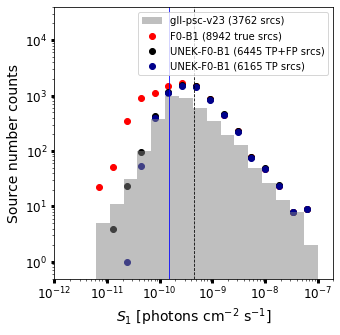

0

In [12]:
plot24_F1000(path_to_stat, "UNEK", [1.5e-10, 4.5e-10])

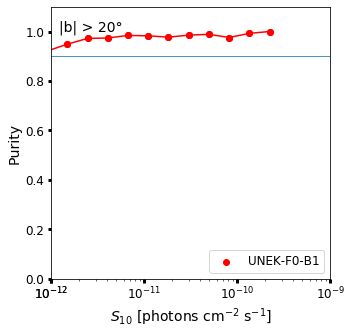

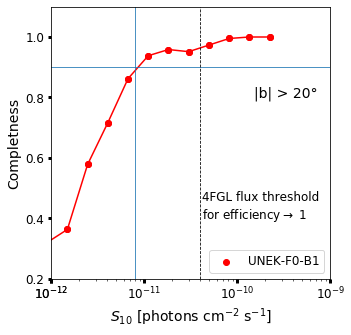

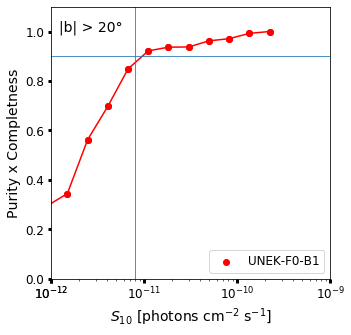

0

In [13]:
legend_loc = "best"

plot_metrics_flux_F10000_latabove(path_to_stat, legend_loc, f"UNEK-F0-B1", 20, 50,
                        vthreshold=[7.8e-13, 8e-12, 8e-12])

#### F1000, lat < 20 deg

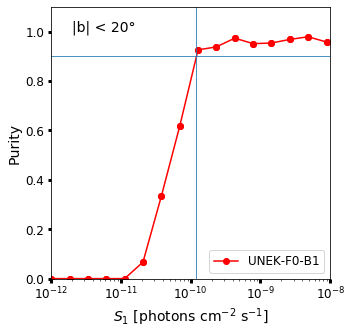

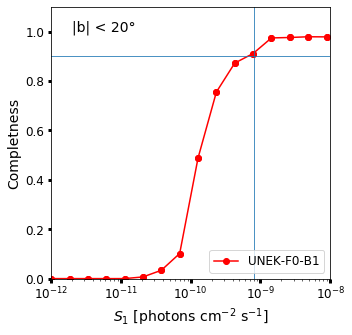

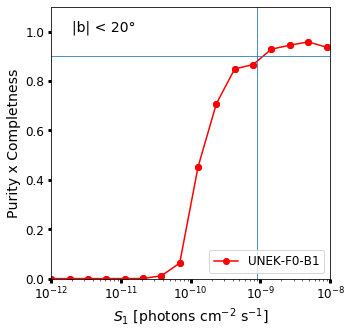

0

In [14]:
legend_loc = "best"

plot_metrics_flux_F1000_latbelow(path_to_stat, legend_loc, 20, 0,
                                 vthreshold=[1.2e-10, 8.1e-10, 9e-10])

### F1000, lat > 20 deg

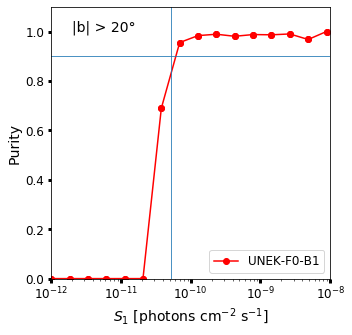

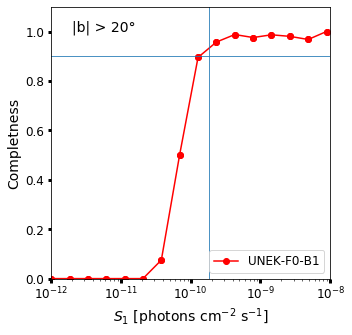

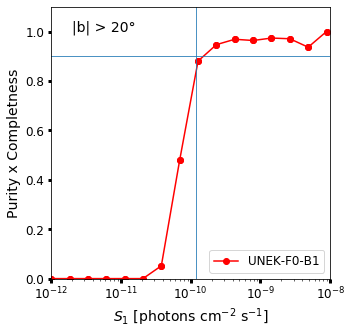

0

In [15]:
legend_loc = "best"

plot_metrics_flux_F1000_latabove(path_to_stat, legend_loc, 20, 0,
                        vthreshold=[5.3e-11, 1.8e-10, 1.2e-10])

#### SNR plots

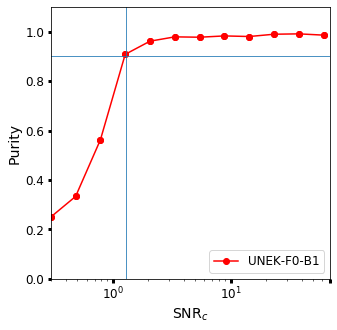

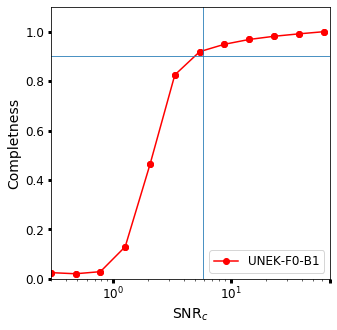

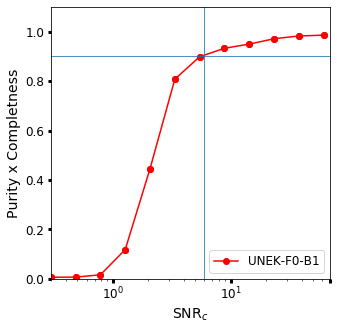

0

In [25]:
legend_loc = "best"

plot_metrics_snr_all(path_to_stat, legend_loc, 2,
                 vthreshold=[1.3, 5.8, 6.0])

#### SBR plots

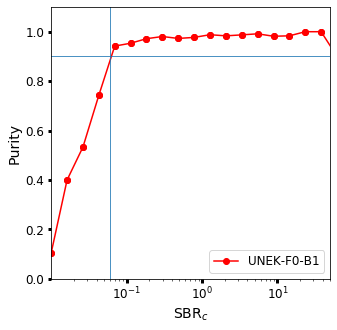

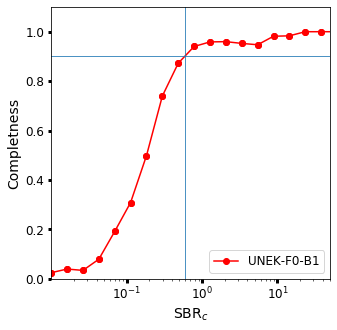

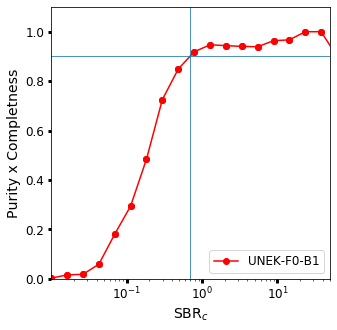

0

In [31]:
legend_loc = "best"

plot_metrics_sbr_all(path_to_stat, legend_loc, 2,
                 vthreshold=[0.06, 0.6, 0.7])